In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import helperfuns
from helperfuns import *
from numpy.lib.scimath import sqrt as csqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from helperfuns import *
fig_directory = '/Users/taliaborofsky/Documents/\
PhD Research/PopDynamics_SocLearning/PopDynamics_TeX/Figures_NoDelay'
green, yellow, purple, red, blue, orange = '#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462'
from matplotlib.collections import LineCollection

from equilibria_analysis_funs import *
import multiprocessing as mp
from itertools import repeat
from equilibriumfuns import *
import numpy.ma as ma

# to make plots clearer
#import seaborn as sns
#sns.set_context('paper', font_scale=1.5)
%matplotlib inline 
%config InlineBackend.figure_format='retina'


# Find $s^*$

In [2]:
"""
mycbrt works for complex numbers and negative real numbers.
vectorized
"""
def mycbrt(x):
    x = np.asarray(x)*np.ones(1)# in case x is a scalar
    mask = (np.isreal(x)) & (np.real(x)<0)
    ans = np.zeros_like(x)
    ans[mask] = -np.abs(x[mask])**(1/3)
    ans[~mask] = x[~mask]**(1/3)
    return(ans)

"""
using cubic formula from https://mathworld.wolfram.com/CubicFormula.html
 cubic of form c3 x**3 + c2 x**2 + c1 x + c0
 get in form z**3 + a2 z**2 + a1 *z + a0

 @return: solns (an np.array of the solutions)
"""
def roots_cubic(c3,c2,c1,c0):


    
    a2 = c2/c3
    a1 = c1/c3
    a0 = c0/c3
    
    Q = (3*a1 - a2*a2)/9
    R = (9*a2*a1 - 27*a0 - 2*a2**3)/54
    D = Q**3 + R**2

    S = mycbrt(R + np.sqrt(D + 0j))
    T = mycbrt(R - np.sqrt(D + 0j))
    
    solns = np.array([-(1.0/3)*a2 + (S+T), 
                     -(1.0/3)*a2 - 0.5*(S+T) + 0.5*np.sqrt(3)*(S-T)*1j,
                      -(1.0/3)*a2 - 0.5*(S+T) - 0.5*np.sqrt(3)*(S-T)*1j])
    
    return solns

def eigenvalues_E2(u, r, N, K, pc, R, δ, β):
    L = (δ - R)/(r - R)
    W = 1 + δ
    a = K*(r - R)
    b = L + R*pc*(r - R)/(r+R)**2
    c = (K/W)*(1+r- u*(r-R))
    d = (L/W)*(1 - u) + pc*R/(W*(r+R)**2)*(1+r - u*(r-R))
    e = -r*β*L/(1+r)
    f = -K*N*r*β/(1+r)
    g = 1/(1+r) - N*r*β*R*pc/((1+r)*(r+R)**2)
    evals = roots_cubic(c3=1,c2 = -(1+c+g),
                        c1 = c + g + c*g -b*e - d*f,
                        c0 = d*f + b*c*e - a*d*e - c*g)
    return np.abs(evals)
    
def internal_stability(u, r, N, K, pc, R, δ, β):
    evals = eigenvalues_E2(u, r, N, K, pc, R, δ, β)
    mags = np.abs(evals)
    return np.max(mags,0) < 1
        
get_u_hat_v = np.frompyfunc(get_u_hat, 3, 1)

def get_trajectory(u_r,u_R,x_r,x_R,N,r,R,beta,delta,K,pc,tsteps, dk = 0, dpc = 0):
    # TO-DO: Check this works!!!
    u_r_vec = np.zeros(tsteps); u_r_vec[0] = u_r
    u_R_vec = np.zeros(tsteps); u_R_vec[0] = u_R
    x_r_vec = np.zeros(tsteps); x_r_vec[0] = x_r
    x_R_vec = np.zeros(tsteps); x_R_vec[0] = x_R
    N_vec = np.zeros(tsteps); N_vec[0] = N;
    r_vec = np.zeros(tsteps); r_vec[0] = r;
    NextGenV = np.frompyfunc(NextGen,13,7)
    for t in range(1,tsteps):
        out = NextGenV(u_r,u_R,x_r,x_R,N,r,R,beta,delta,K,pc,dk,dpc)
        u_r, u_R, x_r, x_R, W, N, r = np.array(list(out), dtype=float)
        u_r_vec[t], u_R_vec[t], x_r_vec[t], x_R_vec[t], N_vec[t], r_vec[t] = u_r, u_R, x_r, x_R, N, r
    return(u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W)

def Jstar_(u_r, r):
    print('TO-DO')

In [3]:
run_generate_smaxvecs = False

In [4]:
Rvals = np.array([0.1, 0.1, 0.4, 0.2])
δvals = np.array([0.15, 0.2, 0.5, 0.5])
muvals = np.linspace(-1,1,2000)
if run_generate_smaxvecs:
    muvals = np.linspace(-1,1,2000)

    μmat, whichRδ = np.meshgrid(muvals, [0,1,2,3])
    μ, whichRδ = [np.ndarray.flatten(item) for item in [μmat, whichRδ]]
    Rvals = np.array([0.1, 0.1, 0.4, 0.2])
    δvals = np.array([0.15, 0.2, 0.5, 0.5])
    R = Rvals[whichRδ]
    δ = δvals[whichRδ]
    list_param_vecs = np.array([μ, R, δ]).T


    print("Number of processors: ", mp.cpu_count())
    # Step 1: Init multiprocessing.Pool()


    pool = mp.Pool(mp.cpu_count())
    out = pool.map(custmax_s_2,list_param_vecs)

    pool.close()
    outmat = np.vstack(out)

    s0, s1, Nβ0, Nβ1 = outmat.T
    μ, R, δ = list_param_vecs.T
    df = pd.DataFrame({'s0':s0, 's1':s1, 'Nβ0':Nβ0, 'Nβ1':Nβ1,
                      'mu':μ, 'R':R, 'delta':δ })
    df.to_csv('lines_sstar.csv')
else:
    df = pd.read_csv('lines_sstar.csv')
df = df.drop(labels = 'Unnamed: 0', axis = 1)

## Result: All of the equilibria corresponding to the $s^*$ values are internally stable

In [29]:
df.head()

β = 0.01
s0, s1, R, δ, μ = df[['s0','s1','R','delta','mu']].values.T
norms = scs.norm(df.mu)

# corresponding to s0
K0 = Kfun(df.s0, norms)
pc0 =  pcfun(df.s0, norms)
r0 = get_r_hat_v(K0, pc0, δ, R)[0]

u0 = np.array(get_u_hat_v(r0, δ, R),dtype=float)
N0 = get_N_hat(r0, δ, R, β)

K1 = Kfun(s1, norms)
pc1 = pcfun(s1, norms)
r1 = get_r_hat_v(K1, pc1, δ, R)[0]

u1 = np.array(get_u_hat_v(r1, δ, R), dtype = float)
N1 = get_N_hat(r1, δ, R, β)

internal_stability_0 = internal_stability(u0, r0, N0, K0, pc0, R, δ, β)

internal_stability_1 = internal_stability(u1, r1, N1, K0, pc0, R, δ, β)


## $s^*$ plots

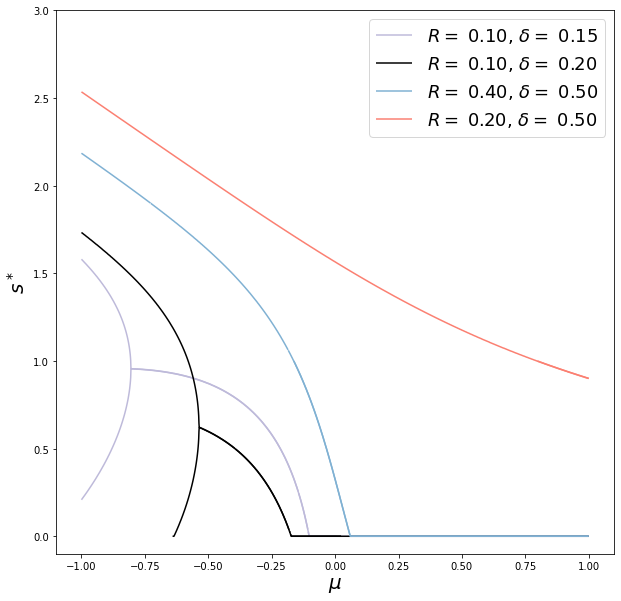

In [30]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

Rδ_combos = np.stack([Rvals,δvals]).T
#lines = []
colors = [purple, 'k', blue, red]
for i,Rδ in enumerate(Rδ_combos):
    R, δ = Rδ
    df_use = df.loc[(df.R==R) & (df.delta == δ),:]
    datamat = df_use.values.T
    s0,s1,Nβ0, Nβ1,_,_,_ = datamat
    lab = r'$R = $ %.2f, $\delta = $ %.2f'%(R,δ)
    line = LineCollection([list(zip(muvals,y)) for y in [s0, s1]], 
                        color = colors[i], label = lab)
    
    ax.add_collection(line)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-0.1,3])

ax.set_xlabel(r'$\mu$', fontsize = 20)
ax.set_ylabel(r'$s^*$', fontsize = 20)

ax.legend(fontsize=18)
fig.savefig(fig_directory + '/Optimals_RlessthanDelta.jpg',dpi=600)

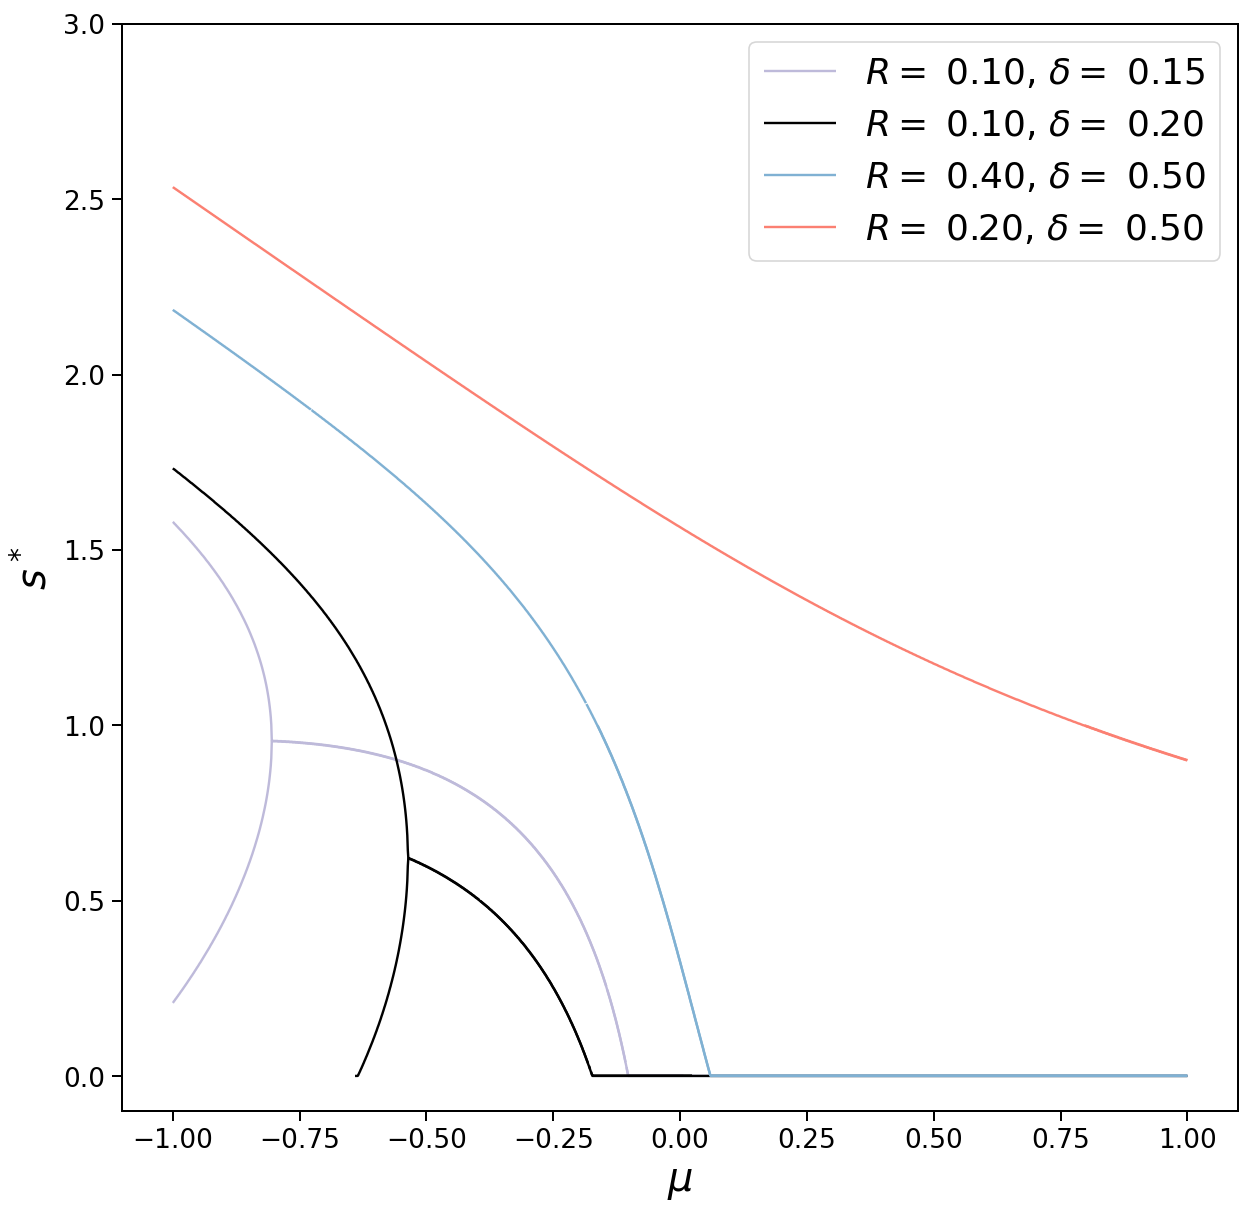

In [235]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

Rδ_combos = np.stack([Rvals,δvals]).T
#lines = []
colors = [purple, 'k', blue, red]
for i,Rδ in enumerate(Rδ_combos):
    R, δ = Rδ
    df_use = df.loc[(df.R==R) & (df.delta == δ),:]
    datamat = df_use.values.T
    s0,s1,Nβ0, Nβ1,_,_,_ = datamat
    lab = r'$R = $ %.2f, $\delta = $ %.2f'%(R,δ)
    line = LineCollection([list(zip(muvals,y)) for y in [s0, s1]], 
                        color = colors[i], label = lab)
    
    ax.add_collection(line)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-0.1,3])

ax.set_xlabel(r'$\mu$', fontsize = 20)
ax.set_ylabel(r'$s^*$', fontsize = 20)

ax.legend(fontsize=18)
fig.savefig(fig_directory + '/Optimals_RlessthanDelta.jpg',dpi=600)

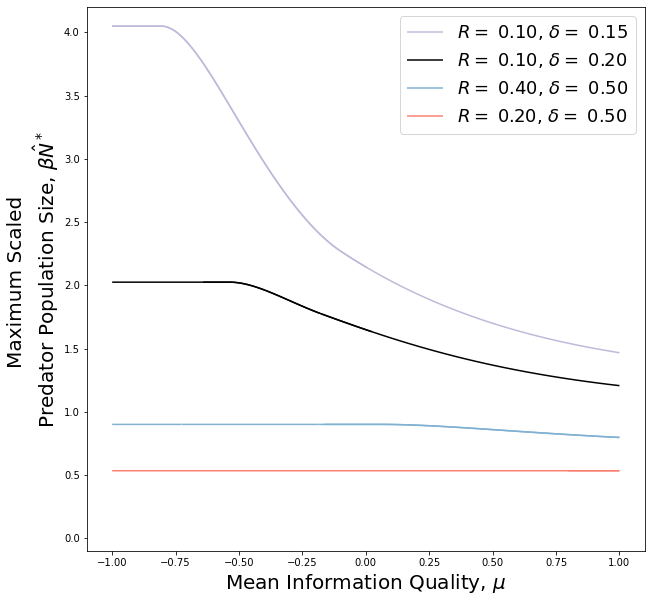

In [32]:
labelformat = dict(fontsize = 20)
titleformat = dict(fontsize = 20)
legendfont = dict(fontsize = 18)

fig,ax = plt.subplots(1,1,figsize=(10,10))

Rδ_combos = np.stack([Rvals,δvals]).T
#lines = []
colors = [purple, 'k', blue, red]
for i,Rδ in enumerate(Rδ_combos):
    R, δ = Rδ
    df_use = df.loc[(df.R==R) & (df.delta == δ),:]
    datamat = df_use.values.T
    s0,s1,Nβ0, Nβ1,_,_,_ = datamat
    lab = r'$R = $ %.2f, $\delta = $ %.2f'%(R,δ)
    line = LineCollection([list(zip(muvals,y)) for y in [Nβ0, Nβ1]], 
                        color = colors[i], label = lab)
    
    ax.add_collection(line)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-0.1,4.2])

ax.set_xlabel(r'Mean Information Quality, $\mu$', **labelformat)
ax.set_ylabel('Maximum Scaled \nPredator Population Size, '+r'$\beta \hat{N}^*$', **labelformat)

ax.legend(**legendfont)
#fig.savefig(fig_directory + '/OptimalN_RlessthanDelta.jpg',dpi=600)



In [236]:
def fig_sizes_vs_s(R, δ, mu):
    
    fig,ax = plt.subplots(1,1,figsize=(8,6))


    svec = np.linspace(0,3,1000)
    Kvec = Kfun(svec, scs.norm(mu))
    pcvec = pcfun(svec, scs.norm(mu))
    rvec = get_r_hat_vec1(Kvec, pcvec, δ, R)
    uvec = u_r_hat(rvec,R,δ)
    
    plt.plot(Kvec,get_Nβ_r(rvec, δ, R), color = 'k', label = r'$β\hat{N}$')
    plt.plot(Kvec, rvec, color = red, label = r'$\hat{r}$')
    plt.plot (Kvec, uvec, color = blue, label = r'$\hat{u}_r$')

    plt.xlabel('Social Learning Probability, K', **labelformat)
    plt.ylabel('Size', **labelformat)
    #plt.ylabel(r'$\hat{N}β$ or $\hat{r}$ or $\hat{u}_r$', **labelformat)
    plt.legend(**legendfont)
    t = r'$\mu = $%.2f, $R = $ %.2f, $\delta = $ %.2f'%(mu,R,δ)
    plt.title(t, **titleformat)
    
    return(fig)




0.1224244848969794 1.0757614477886577


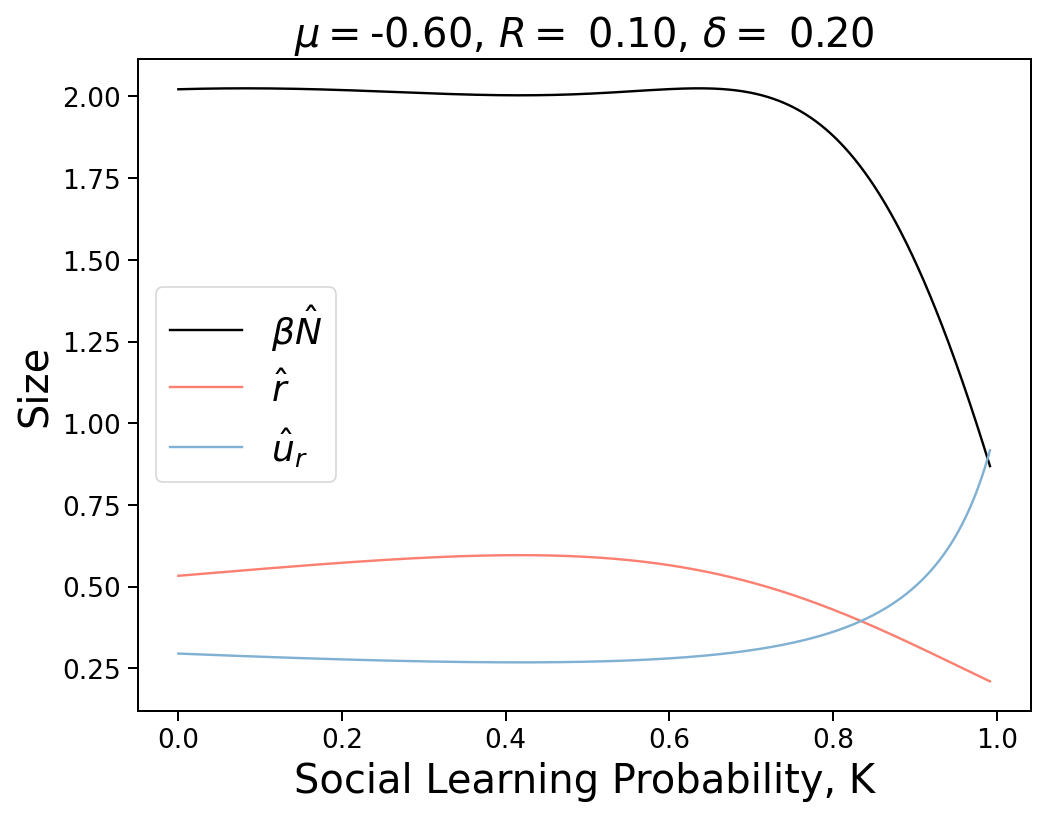

In [241]:
s0, s1, _, _ = custmax_s_2([-0.6,0.1,0.2])
K0, K1 = (Kfun(s0, scs.norm(-0.6)), Kfun(s1, scs.norm(-0.6)))
fig1 = fig_sizes_vs_s(R = 0.1, δ = 0.2, mu = -0.6)
fig1.savefig(fig_directory + '/Weird_s_u_r_N.jpg',dpi=600)

print(s0, s1)

Increasing social learning makes little difference until around K = 0.8. Then an increase in $\hat{u}_r$ seems to cause a decline in CP density $\hat{r}$ and subsequently a decline in predator population size $\hat{N}$.

In [229]:




    
# # need to add a trajectory to last plot
# K = Kfun(s,scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
# rhat = get_r_hat(K,pc,delta,R)[0]
# Nhat = get_N_hat(rhat,delta,R,beta)
# uhat = get_u_hat(rhat,delta,R)

# r = .38
# N = Nhat
# u_r = uhat;
# x_r = 0; x_R = 0
# traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
# u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W = traj
# cs = plot_colourline(r_vec,N_vec,u_r_vec,minc=0,maxc=1,ax=ax, cmapAnchor=False, cmap = cmap,hl=20,hw=20)

# # add another trajectory close to E0
# r = 0.05
# N = 1
# u_r = 0.05
# traj = get_trajectory(u_r, 1 - u_r, x_r, x_R, N, r, R, beta, delta, K, pc, tsteps)
# u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W = traj
# cs = plot_colourline(r_vec,N_vec,u_r_vec,minc=0,maxc=1,ax=ax, cmapAnchor=False, cmap = cmap,hl=20,hw=20)




#    return rhat_list, Nhat_list, uhat_list, fig
    #fig.savefig(fig_directory + '/Trajectories_R01_delta02_beta01.jpg',dpi=600)

## Trajectory plots:
$\mu = -0.6$, $R = 0.1, \delta = 0.2$, do two $s^*$ values and somewhere in between

In [94]:
params = mu, R, δ
sstar = custmax_s_2(params)
sstar0, sstar1, _, _ = sstar
s2, s3 = [sstar0 + (sstar1 - sstar0)/2, 2]
svals = np.array([sstar0,s2,sstar1,s3])

np.full(svals.shape,[1,2.1,3,4])

array([1. , 2.1, 3. , 4. ])

<Figure size 432x288 with 0 Axes>

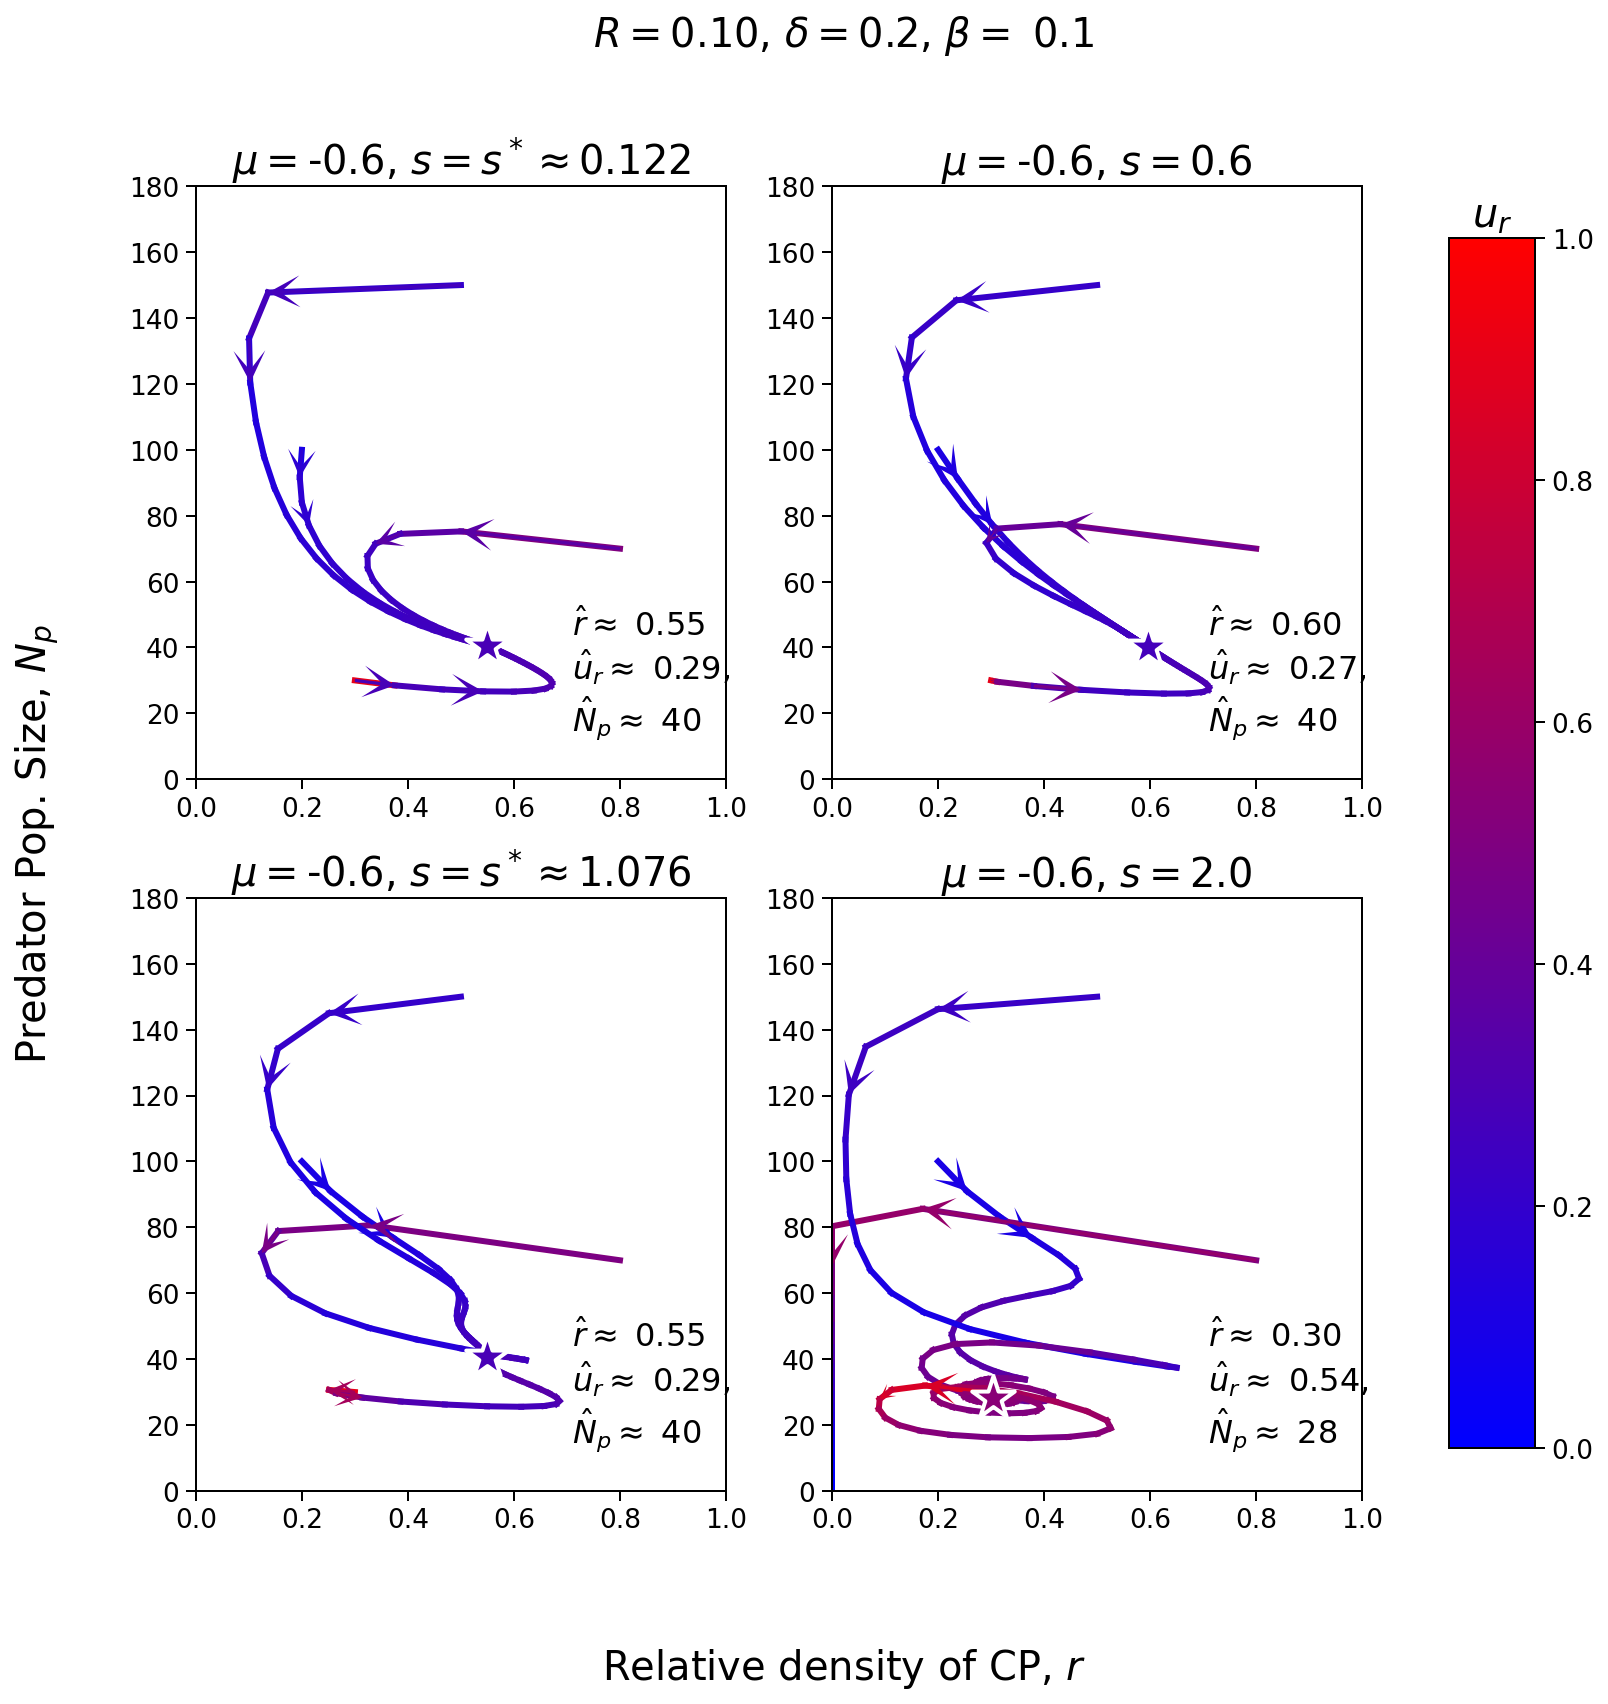

In [230]:
# parameters

β = 0.05
μ = -0.6
R = 0.1
δ = 0.2
svals = [sstar0,s2,sstar1,s3]
tsteps = 500


# set up figures
fig, axs, cmap = format_traj_plots_with_cbar(nrows=2, ncols=2, R=R, δ=δ, β = β)

# for storing equilibria
rhat_list = [[],[],[],[]]
Nhat_list = [[],[],[],[]]
uhat_list = [[],[],[],[]]

# plot trajectories
for i, ax in enumerate(axs.flatten()):
    s = svals[i]
    #trajs, rhats,lambdas,mags = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    trajs, rhats, Nhats, uhats = plot_Nru_traj(ax, R, δ, μ, s, β,
                                               tsteps, cmap, minu=0, 
                                               maxu=1, 
                                               Nvals = [100,70,150,30],
                                               hl=10,hw=10)
    rhat_list[i] =  rhats
    Nhat_list[i] =  Nhats
    uhat_list[i] =  uhats

    if i == 0 or i == 2:
        ts = r'$\mu=$%.1f, $s=s^*\approx$%.3f' %(mu,s)
    else:
        ts = r'$\mu=$%.1f, $s=$%.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)

    annotation = r'$\hat{r} \approx$ %.2f'%(rhats[0]) \
        + "\n" + '$\hat{u}_r$' +r'$\approx$ %.2f,' %(uhats[0]) \
        + "\n" + '$\hat{N}_p$' +r'$\approx$ %.0f' %(Nhats[0])
    ax.annotate(annotation,xy = (0.71,15), fontsize = 16)
        

fig.savefig('Trajectories_weird_sstar1.jpg', dpi=600)

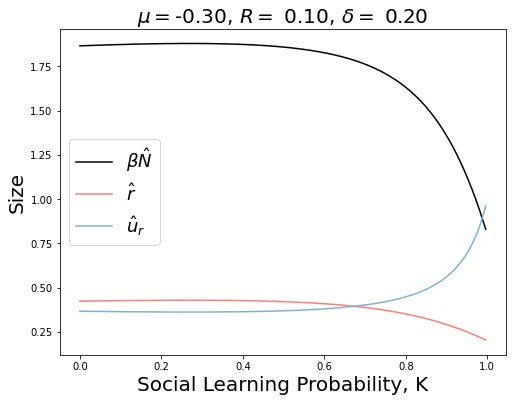

In [114]:
#fig.savefig(fig_directory + '/Sizes_vs_K_muRdelta1.jpg',dpi=600)
fig2 = fig_sizes_vs_s(R = 0.1, δ = 0.2, mu = -0.3)

Like above, increasing social learning makes little difference until around K = 0.8. Then an increase in $\hat{u}_r$ seems to cause a decline in CP density $\hat{r}$ and subsequently a decline in predator population size $\hat{N}$.

It's interesting how the $s*$ plot makes these look like very different situations, but here they do not look so different. Next we should find stability

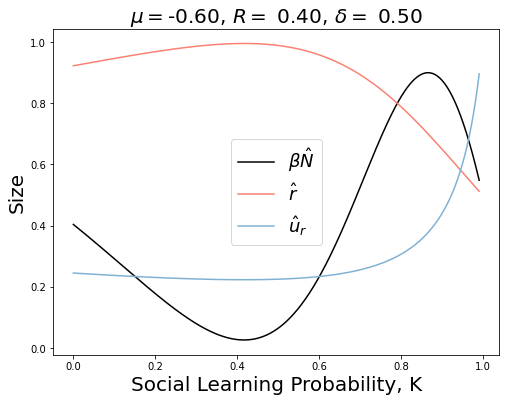

In [116]:
fig3 = fig_sizes_vs_s(R = 0.4, δ = 0.5, mu = -0.6)

Now there's a super nonlinear relationship between social learning and predator population size. Intermediate values of social learning are bad for the predators, WHY?

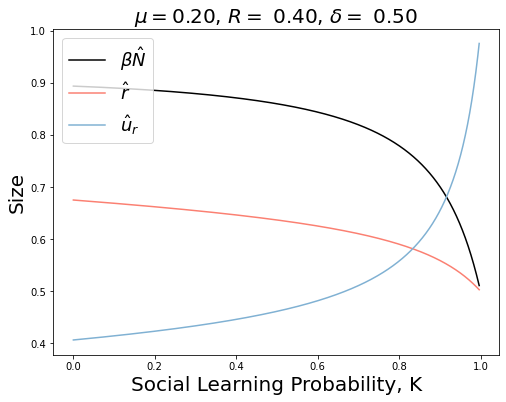

In [117]:
fig4 = fig_sizes_vs_s(R = 0.4, δ = 0.5, mu = 0.2)

The CP behavior takes over the population as K increases to 1. Social learning seems to lock the population into harvesting the CP even as the CP population size shrinks.

Text(0.5, 1.0, '$\\mu = $0.25, $R = $ 0.40, $\\delta = $ 0.50')

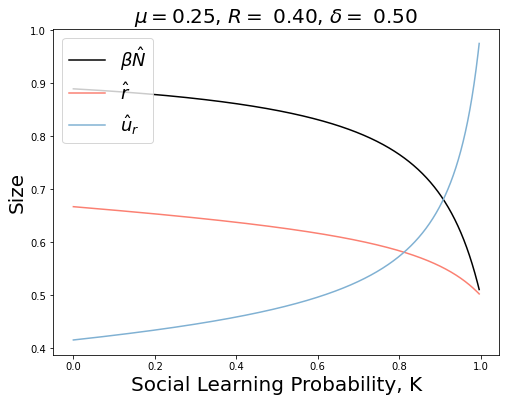

# Find $ \tilde{s}$ for $\tilde{L}$

In [4]:
run_generate_stildevecs = True

In [7]:
from pathos.multiprocessing import ProcessingPool as Pool

In [ ]:

if run_generate_stildevecs:
    df = pd.read_csv('lines_sstar.csv')
    df = df.drop(labels = ['Unnamed: 0', 's_tilde'], axis = 1)
    # get parameters from df generated when found sstar plots

    array_param_vecs = df[['mu','R','delta']].values
    μ, R, δ = array_param_vecs.T
    
    # find the actual L-tilde values and the correspondong r and u_r values at equilibrium
    L_tilde, r_tilde = np.array(get_tilde_L(δ,R)), get_tilde_r(R)
    u_tilde = get_tilde_u(L_tilde, δ, R)
    df['L_tilde'] = L_tilde
    df['r_tilde'] = r_tilde
    df['u_tilde'] = u_tilde
    
    # prepare for parallel computing
    
    cores = mp.cpu_count()
    
    
    array_param_vecs_split = np.array_split(array_param_vecs,cores)
    array_param_vecs_split = list(map(np.transpose,array_param_vecs_split))


    # Step 1: Initiate Pool
    pool = Pool(cores)
    
    # Map function to find s_tilde to the pool
    out = pool.map(find_s_tilde_v,array_param_vecs_split)
    s_out = np.concatenate(out,axis = 0)
    pool.close()
    pool.join()
    pool.clear()
    
    df['s_tilde_approx'] = s_out
    
    norms = scs.norm(μ)
    K_t = Kfun(s_out, norms)
    pc_t = pcfun(s_out, norms)
    
    L_stilde_approx = K_t*u_tilde + pc_t*r_tilde/(r_tilde + R)
    df['L_stilde_approx'] = L_stilde_approx
    df['L_stilde_error'] = np.abs(L_tilde - L_stilde_approx)
    df.to_csv('lines_sstar.csv')
    #df.to_csv('lines_sstar_sample.csv')

    
else:
    df = pd.read_csv('lines_sstar.csv')
#df = df.drop(labels = 'Unnamed: 0', axis = 1)